In [8]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.signal import savgol_filter
import folium

In [9]:
# Read the CSV file
filename = "data/session.location.27-09-2024.23-13-02.csv"
data = pd.read_csv(filename)
df = data.copy()

In [19]:
# Convert timestamp to datetime
df['time'] = (df['timestamp'] - df['timestamp'][0]) / 1e9  # Convert to seconds from start
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
# Calculate time difference in seconds between consecutive points
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()

In [11]:
# Define a function to calculate distance between two lat/lon points
def calculate_distance(row):
    if pd.isnull(row['latitude_prev']):
        return 0
    else:
        prev_point = (row['latitude_prev'], row['longitude_prev'])
        current_point = (row['latitude'], row['longitude'])
        return geodesic(prev_point, current_point).meters

# Shift latitude and longitude to get previous points
df['latitude_prev'] = df['latitude'].shift(1)
df['longitude_prev'] = df['longitude'].shift(1)

# Apply the function to calculate distances
df['distance'] = df.apply(calculate_distance, axis=1)

In [16]:
# Calculate velocity in km/h
df['velocity'] = df['distance'] / df['time_diff'] * 3.6

# Handle possible infinite or NaN values
df['velocity'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['velocity'].fillna(0, inplace=True)

/var/folders/mg/g68_x7rd3sd_84v13l12gw8h0000gn/T/ipykernel_25051/1592876425.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['velocity'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/mg/g68_x7rd3sd_84v13l12gw8h0000gn/T/ipykernel_25051/1592876425.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

In [17]:
# Apply Savitzky-Golay filter
df['velocity_smooth'] = savgol_filter(df['velocity'], window_length=11, polyorder=2)

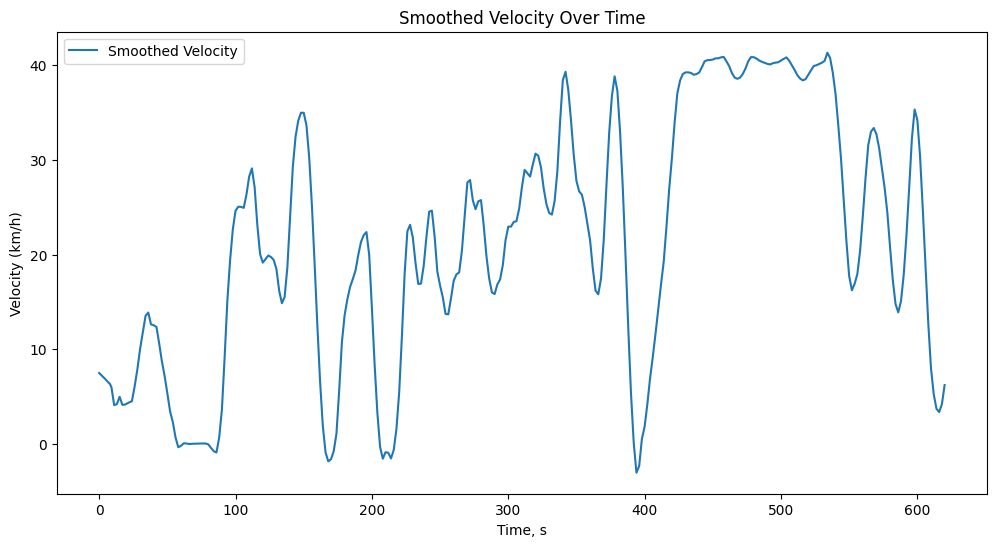

In [21]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['velocity_smooth'], label='Smoothed Velocity')
plt.xlabel('Time, s')
plt.ylabel('Velocity (km/h)')
plt.title('Smoothed Velocity Over Time')
plt.legend()
plt.show()

In [15]:
# Calculate the center of the map
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()

# Create a Folium map
ride_map = folium.Map(location=[center_lat, center_lon], zoom_start=15)

# Create a list of coordinates
coordinates = df[['latitude', 'longitude']].values.tolist()

# Add the path to the map
folium.PolyLine(coordinates, color='red', weight=5, opacity=0.7).add_to(ride_map)

# Display the map
ride_map